In [1]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt 
import seaborn as sns 

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x:ast.literal_eval(x) if pd.notna(x) else x)

# What are the most demanded skills for the top 3 most popular data roles?

## Steps

1. Clean-up skills column
2. Calculate skill count on job_title_short
3. Calculate skill percentage
4. Plot the findings

###  Filtering the data for India

In [2]:
df_IN = df[df['job_country'] == 'India']

### Explode Skills
Converts the job_skills column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row.

In [4]:
df_skills = df_IN.explode('job_skills')

df_skills[['job_title','job_skills']]

,job_title,job_skills
16,Big Data Engineer,powershell
16,Big Data Engineer,python
16,Big Data Engineer,sql
16,Big Data Engineer,mysql
16,Big Data Engineer,sql server
...,...,...
785716,Application Support Analyst,c#
785716,Application Support Analyst,sql
785718,Senior Performance QA Analyst,None
785740,AWS System Analyst,aws


### Count Skills per Job Title

Groups DataFrame by job_skills and job_title_short, counting the occurrences of each skill within each job title.

In [9]:
df_skills_count = df_skills.groupby(['job_skills','job_title_short']).size()

# type(df_skills_count)

df_skills_count = df_skills_count.reset_index(name='skill_count')

df_skills_count.sort_values(by='skill_count',ascending=False,inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1374,sql,Data Engineer,12993
1088,python,Data Engineer,11568
1089,python,Data Scientist,9248
1327,spark,Data Engineer,7157
103,aws,Data Engineer,6993
...,...,...,...
389,esquisse,Data Scientist,1
887,node.js,Senior Data Analyst,1
753,matlab,Cloud Engineer,1
411,fastapi,Cloud Engineer,1


### For creating list of Top 3 roles

In [10]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3]) #In alphabetical order

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

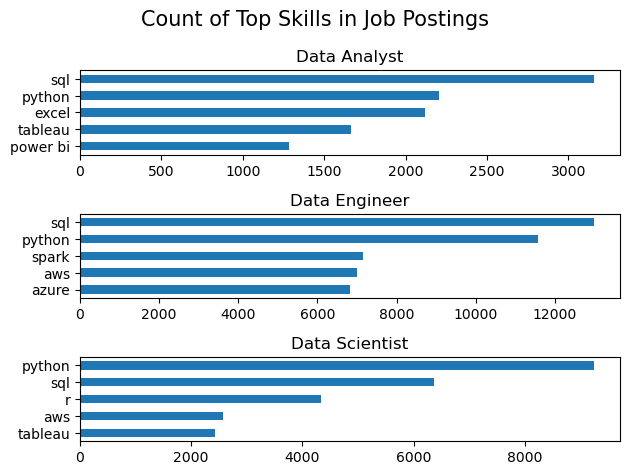

In [13]:
fig, ax = plt.subplots(len(job_titles),1)

for i, job_title in enumerate(job_titles):
  df_plot = df_skills_count[df_skills_count['job_title_short']==job_title].head(5)
  df_plot.plot(kind='barh', x='job_skills', y='skill_count', ax=ax[i], title=job_title)
  ax[i].invert_yaxis()
  ax[i].set_ylabel('')
  ax[i].legend().set_visible(False)

fig.suptitle('Count of Top Skills in Job Postings', fontsize=15)
plt.tight_layout()
plt.show()

In [15]:
df_job_title_count = df_IN['job_title_short'].value_counts().reset_index(name='jobs_total')

Merge it with df_skills_count

In [18]:
df_skills_perc = pd.merge(df_skills_count,df_job_title_count, how='left',on='job_title_short')

df_skills_perc['skill_percent'] = 100 * df_skills_perc['skill_count']/df_skills_perc['jobs_total']

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,12993,19062,68.161788
1,python,Data Engineer,11568,19062,60.686182
2,python,Data Scientist,9248,13279,69.643798
3,spark,Data Engineer,7157,19062,37.545903
4,aws,Data Engineer,6993,19062,36.685552
...,...,...,...,...,...
1684,esquisse,Data Scientist,1,13279,0.007531
1685,node.js,Senior Data Analyst,1,1083,0.092336
1686,matlab,Cloud Engineer,1,351,0.284900
1687,fastapi,Cloud Engineer,1,351,0.284900


### Plotting

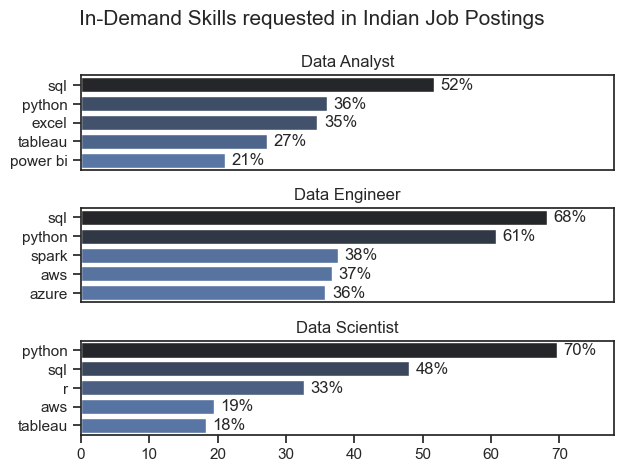

In [33]:
fig, ax = plt.subplots(len(job_titles),1)

sns.set_theme(style='ticks')
for i, job_title in enumerate(job_titles):
  df_plot = df_skills_perc[df_skills_perc['job_title_short']==job_title].head(5)
  #Matplotlib
  # df_plot.plot(kind='barh', x='job_skills', y='skill_percent', ax=ax[i], title=job_title)
  # ax[i].invert_yaxis() #highest to low
  
  #Seaborn for better visualization
  sns.barplot(data=df_plot, x='skill_percent',y='job_skills',ax=ax[i],hue='skill_percent',palette='dark:b_r')
  ax[i].set_title(job_title)
  ax[i].set_ylabel('')
  ax[i].set_xlabel('')
  ax[i].legend().remove()
  ax[i].set_xlim(0,78)

  #For getting percentage labels in visual
  for n, perc in enumerate(df_plot['skill_percent']):
    ax[i].text(perc+1, n, f'{perc:.0f}%', va='center') #va = vertical axis
  
  if i != len(job_titles)-1:
    ax[i].set_xticks([]) #to remove xticks for top 2
fig.suptitle('In-Demand Skills requested in Indian Job Postings', fontsize=15)
plt.tight_layout() #fix the overlap
plt.show()